<a href="https://colab.research.google.com/github/grushilkumar/Larsen-and-Toubro-internship/blob/main/information_extraction(Service_items).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
print(stemmer.stem("excavating"))

excav


In [35]:
print(stemmer.stem("excavation"))

excav


In [38]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [39]:
candidate_sentences = pd.read_excel("/content/datafile.xlsx", sheet_name= 'Service items', skipfooter = 76000)
candidate_sentences.shape

(2061, 1)

In [40]:
candidate_sentences['itemdesc'].sample(5)

2024    All Charges for Erection of MS Pipes on Rack(IS 1239/IS 3589,BE,size 100 NB to 800 NB) Including supply of Labour, consumables, tools & tackles,Plant and Machineries all as required to complete th...
1839                                                                               FtAll charges for construction of Rainwater Harvesting system for Charawas PH, scope inclusive of labour, material, P&M etc.
1786                                                                                                                                                               Alu Profile Vertical Corner External Cutting
261                                                  Labour charge for surface dressing including levelling, making without any undulations, consolidating etc. disposal of earth as directed within the site.;
544     SCOPE :- As described further; DETAILS :- Earth work for Sewer line and Manhole in excavation in foundation, trenches manholes, road side chambers etc. includin

In [41]:
doc = nlp("SCOPE :- Transportation of Cement Treated Sub Base(CTSB) Mix; DISTANCE :- Up to 5 km; FUEL :- HSD - issued by L&T; Work Categorization :- Charges for Specialized work with Tools / P&M")

for tok in doc:
  print(tok.text, "...", tok.dep_)

SCOPE ... ROOT
: ... punct
- ... punct
Transportation ... nsubj
of ... prep
Cement ... pobj
Treated ... acl
Sub ... compound
Base(CTSB ... nmod
) ... punct
Mix ... dobj
; ... punct
DISTANCE ... appos
: ... punct
- ... punct
Up ... quantmod
to ... quantmod
5 ... nummod
km ... appos
; ... punct
FUEL ... appos
: ... punct
- ... punct
HSD ... dep
- ... punct
issued ... acl
by ... agent
L&T ... pobj
; ... punct
Work ... compound
Categorization ... appos
: ... punct
- ... punct
Charges ... appos
for ... prep
Specialized ... amod
work ... pobj
with ... prep
Tools ... nmod
/ ... punct
P&M ... pobj


In [42]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [43]:
get_entities("SCOPE :- Transportation of Cement Treated Sub Base(CTSB) Mix; DISTANCE :- Up to 5 km; FUEL :- HSD - issued by L&T; Work Categorization :- Charges for Specialized work with Tools / P&M")

['Transportation', 'Tools Work P&M']

In [44]:
entity_pairs = []

for i in tqdm(candidate_sentences["itemdesc"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 2061/2061 [00:24<00:00, 83.87it/s]


In [45]:
entity_pairs[10:20]

[['', 'Soil'],
 ['', '30 Mtr EIC'],
 ['', 'Roller substation premises'],
 ['', 'soft DI pipe line'],
 ['', 'L  excavation'],
 ['', 'L  soil'],
 ['', 'L Slush removal'],
 ['', 'borrowed earth filling'],
 ['', 'fine  sand'],
 ['cleared  Clearing', 'earthwork Specifications']]

In [46]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [47]:
get_relation("John completed the task")

'completed'

In [48]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['itemdesc'])]

100%|██████████| 2061/2061 [00:23<00:00, 87.81it/s]


In [49]:
pd.Series(relations).value_counts()[:50]


SCOPE                 230
charges for           183
DETAILS                82
Charges for            69
complete               33
;                      30
includes               28
In                     20
charges towards        19
For                    17
Charges towards        17
c for                  14
complete as            14
Supply                 13
C for                  13
Provisioning of        12
For over               12
as per                 11
paid by                11
include                11
BREAKER                10
is                     10
provided by            10
SPARES FOR             10
charges                10
upto                   10
dressing complete       9
Soil                    9
works                   9
dia                     9
done by                 8
Disposing of            8
work                    8
Construction of         8
.                       7
be                      7
Excavation              7
Cutting                 7
works for   

In [50]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [51]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

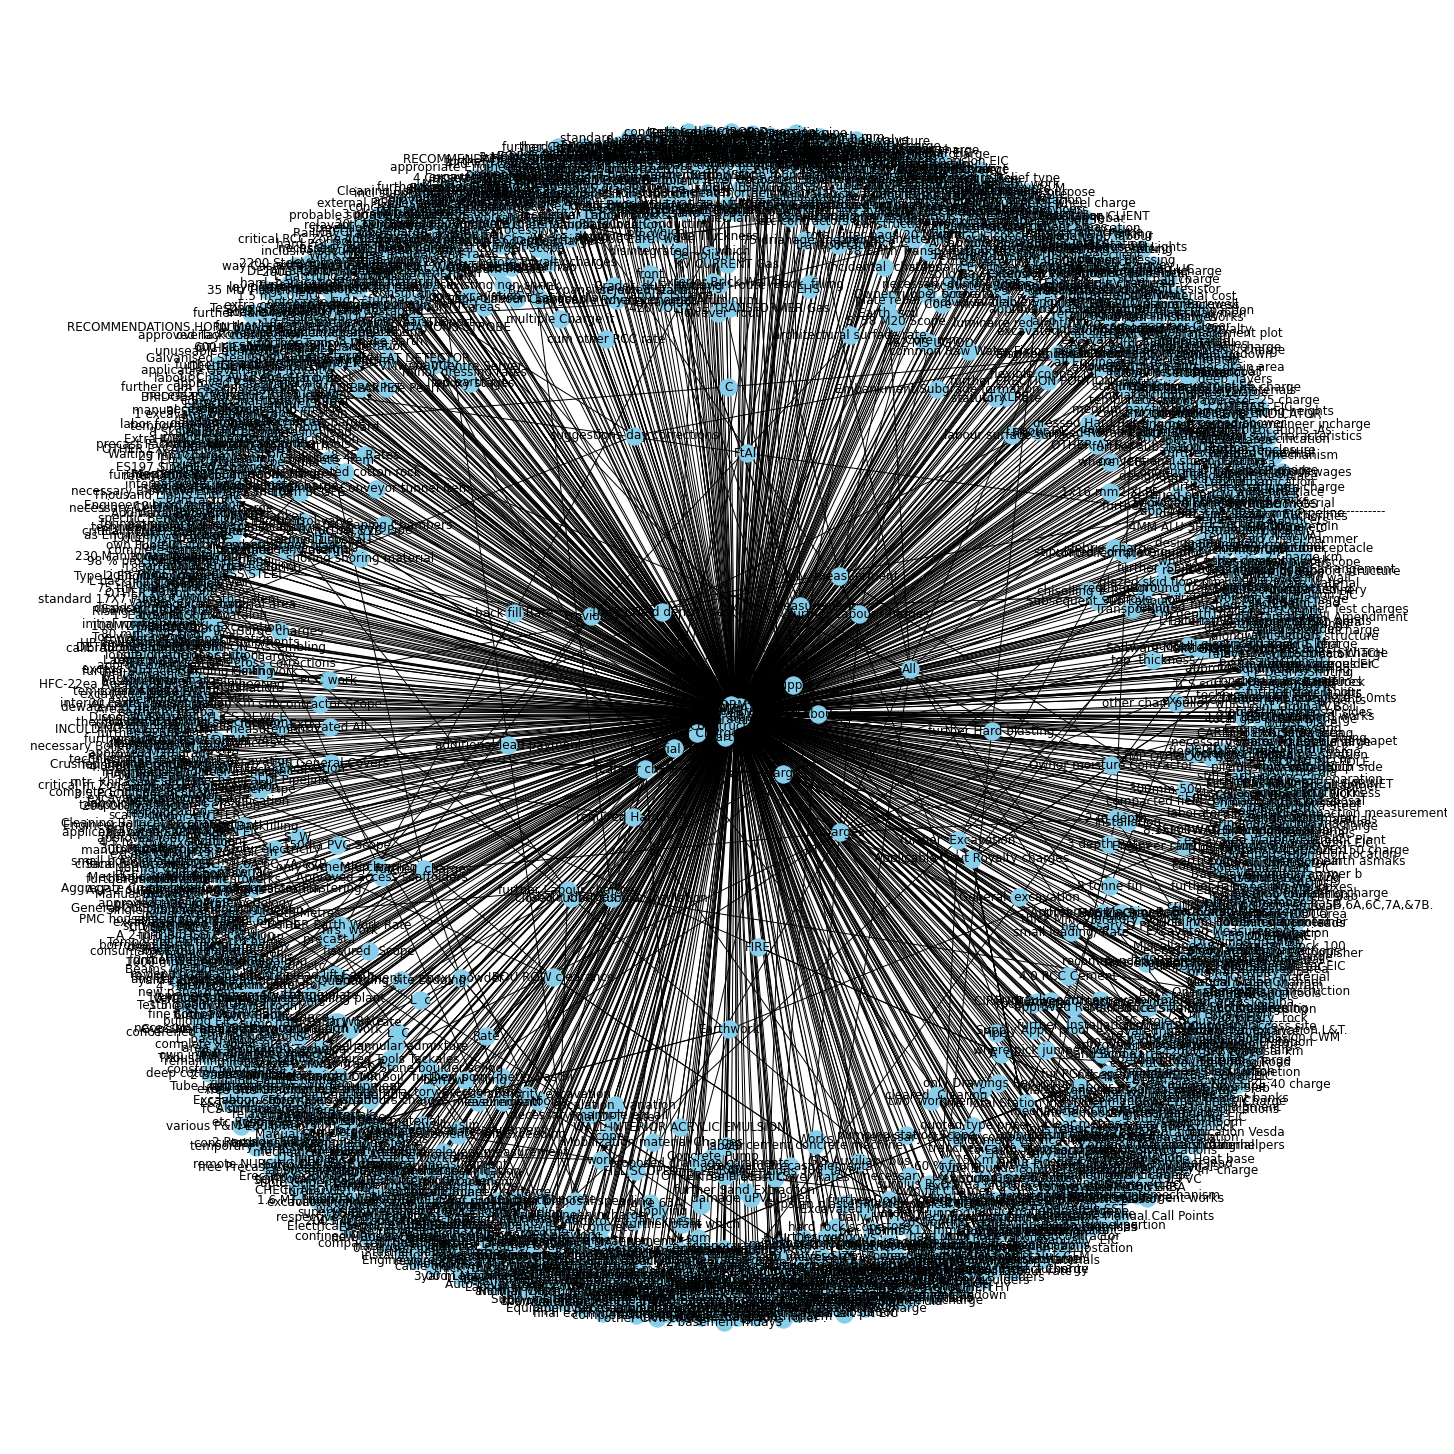

In [55]:
plt.figure(figsize=(20,20))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

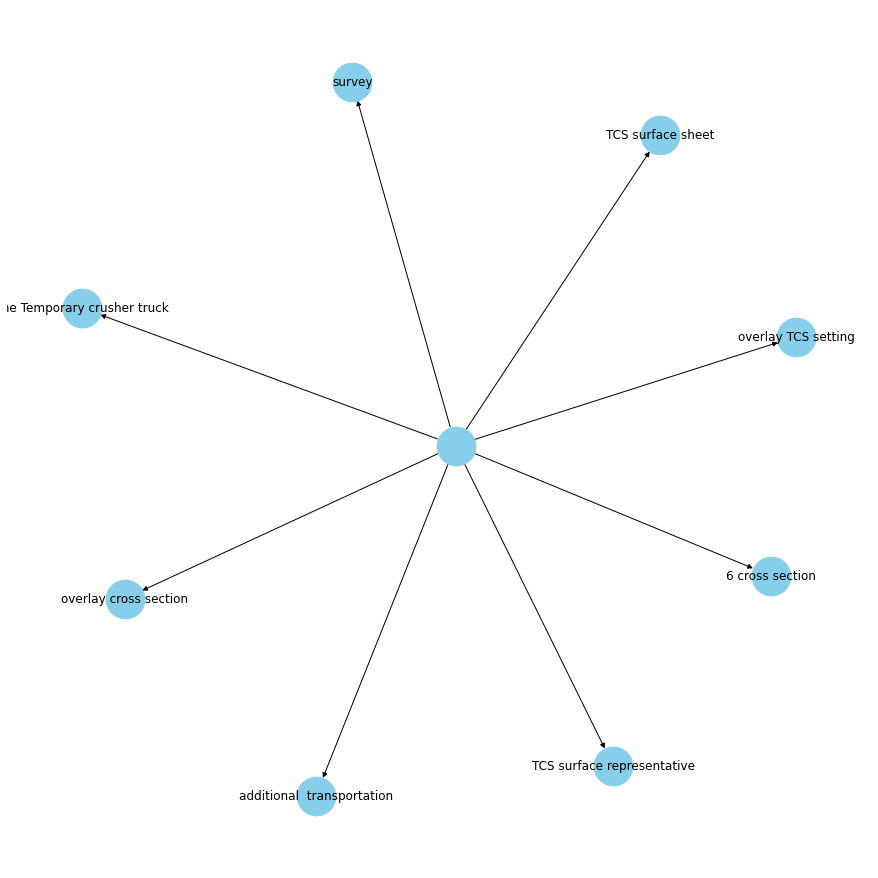

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Construction of"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

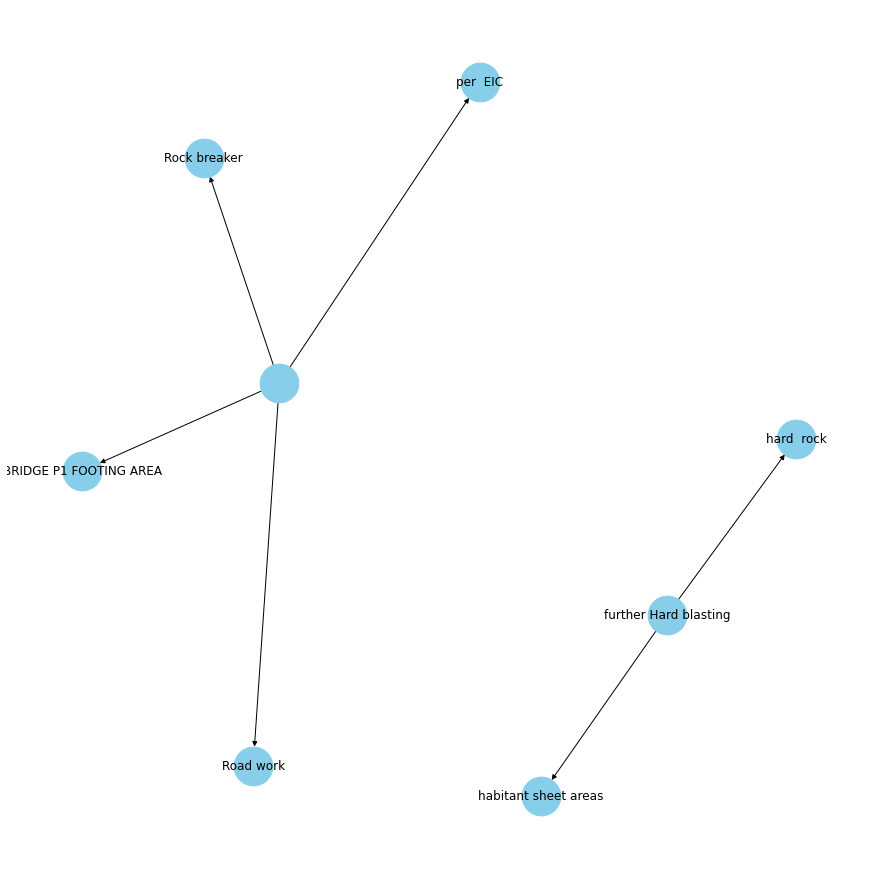

In [19]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Excavation"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

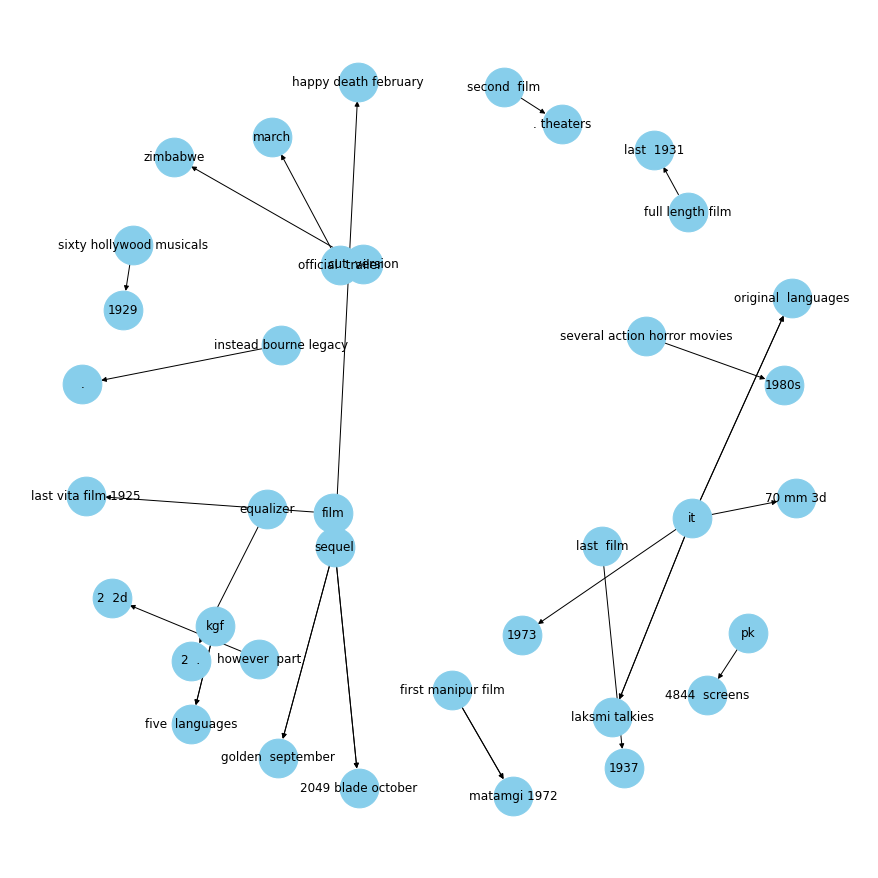

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
4
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()